# Simple Neural Network

Instead of fitting a known equation to a bunch of points and figuring out the parameters, we want to create a neural network that can approximate the function between the known points.

Let's base our data on the known equation

$$
y = a*sin(x) + b*cos(x)
$$

And lets create some sample data assuming $a=5$ and $b=2$

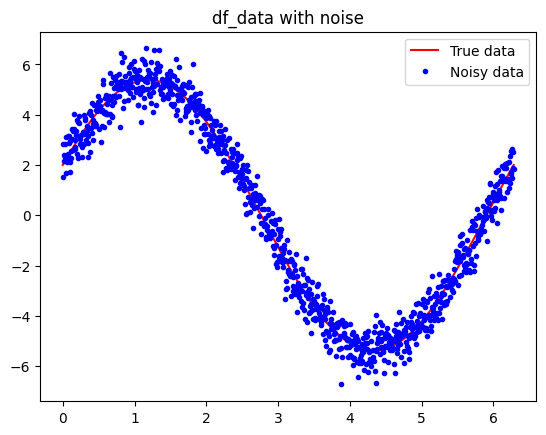

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# params is an array so that we can expand it in the future, it stores a and b

def gen_noisy_data(params, num_points, noise_std):
    x = np.linspace(0, 2 * np.pi, num_points)
    y = params[0] * np.sin(x) + params[1] * np.cos(x)
    noise = np.random.normal(0, noise_std, size=y.shape)
    y_noise = y + noise
    # return the noise free and noisy data
    return pd.DataFrame({'x': x, 'y': y}), \
           pd.DataFrame({'x': x, 'y': y_noise})

true_params = [5, 2] # a, b
num_points = 1000
noise_std = 0.5

df_orig_data, df_data = gen_noisy_data(true_params, num_points, noise_std)

plt.plot(df_orig_data['x'], df_orig_data['y'], 'r', label='True data')
plt.plot(df_data['x'], df_data['y'], 'b.', label='Noisy data')
plt.legend()
plt.title("df_data with noise")
plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# convert the data to torch tensors
x_tensor = torch.tensor(df_data['x'].values, dtype=torch.float32).reshape(-1, 1)
y_tensor = torch.tensor(df_data['y'].values, dtype=torch.float32).reshape(-1, 1)

# train the model
def train_model(model, x_tensor, y_tensor, num_epochs, loss_fn, optimizer):
    losses = [] ### store the loss for each epoch

    for epoch in range(num_epochs):
        # forward pass
        y_pred = model(x_tensor)
        loss = loss_fn(y_pred, y_tensor)

        # backward pass
        optimizer.zero_grad() # erase previous gradients
        loss.backward() # compute gradients
        optimizer.step() # update weights

        # store and print the loss
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, loss {loss.item():.4f}')

    return model, losses

# evaluate the model
def evaluate_model(model, x_tensor):
    with torch.no_grad():
        return model(x_tensor).numpy()

# plot the loss
def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Loss vs. epochs')
    plt.show()

# plot the true data and the predicted data
def plot_data(df_data, y_pred):
    plt.figure(figsize=(10, 5))
    plt.scatter(df_data['x'], df_data['y'], label='True data', color='b', alpha=0.5)
    plt.plot(df_data['x'], y_pred, label='Fitted data', color='r')
    plt.title("Linear Regression Fit")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid()
    plt.show()

# create a function to process the model
def process_model(model, x_tensor, y_tensor, loss_fn, optimizer, num_epochs=1000):
    model, losses = train_model(model, x_tensor, y_tensor, num_epochs, loss_fn, optimizer) # train the model
    y_pred = evaluate_model(model, x_tensor) # evaluate the model
    plot_loss(losses) # plot the loss
    plot_data(df_data, y_pred) # plot the true data and the predicted data
    return model, y_pred


## Try a simple linear model

Epoch 1/1000, loss 13.4505
Epoch 101/1000, loss 9.5518
Epoch 201/1000, loss 8.0861
Epoch 301/1000, loss 7.5186
Epoch 401/1000, loss 7.2988
Epoch 501/1000, loss 7.2138
Epoch 601/1000, loss 7.1808
Epoch 701/1000, loss 7.1681
Epoch 801/1000, loss 7.1631
Epoch 901/1000, loss 7.1612


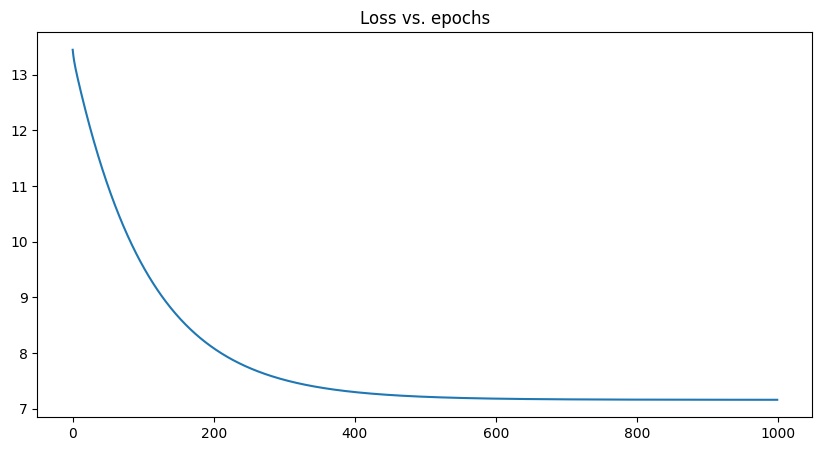

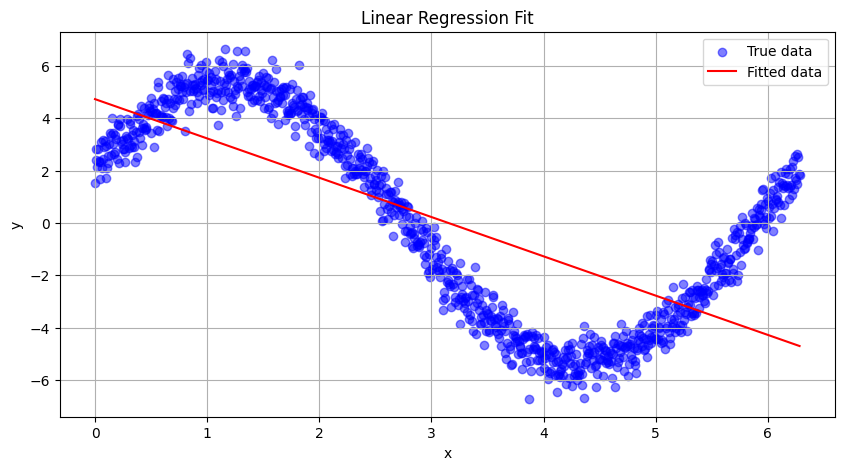

In [3]:
# define the model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

# process the model
model = LinearModel()
loss = nn.MSELoss()
opt = optim.SGD(model.parameters(), lr=0.01)
model, y_pred = process_model(model, x_tensor, y_tensor, loss, opt)


## Try a more complex model

Epoch 1/1000, loss 14.3871
Epoch 101/1000, loss 0.5717
Epoch 201/1000, loss 0.3089
Epoch 301/1000, loss 0.2808
Epoch 401/1000, loss 0.2746
Epoch 501/1000, loss 0.2739
Epoch 601/1000, loss 0.3238
Epoch 701/1000, loss 0.2737
Epoch 801/1000, loss 0.2726
Epoch 901/1000, loss 0.2722


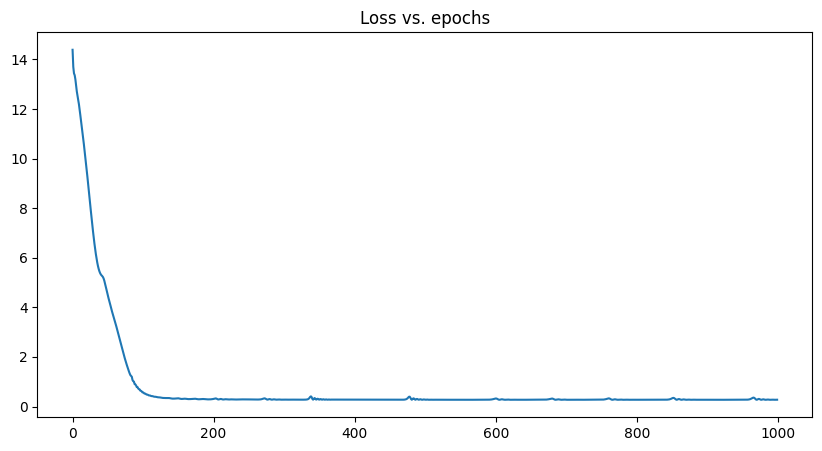

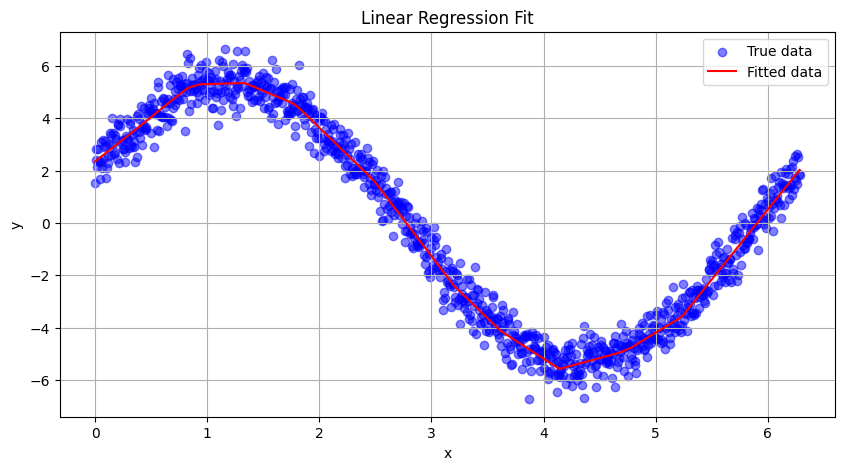

In [7]:
class ComplexNN1(nn.Module):
    def __init__(self):
        super(ComplexNN1, self).__init__()
        self.layer1 = nn.Linear(1, 16)
        self.layer2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.output(x)
        return x
    
model = ComplexNN1()
loss = loss = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=0.01)
model, y_pred = process_model(model, x_tensor, y_tensor, loss, opt)

### Some stats about the complex model

In [8]:
# number of weights per layer
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        total_params += param.numel()
        print(f"Layer: {name}, Parameters: {param.numel()}")

print(f"\nTotal parameters: {total_params}")

Layer: layer1.weight, Parameters: 16
Layer: layer1.bias, Parameters: 16
Layer: layer2.weight, Parameters: 256
Layer: layer2.bias, Parameters: 16
Layer: output.weight, Parameters: 16
Layer: output.bias, Parameters: 1

Total parameters: 321


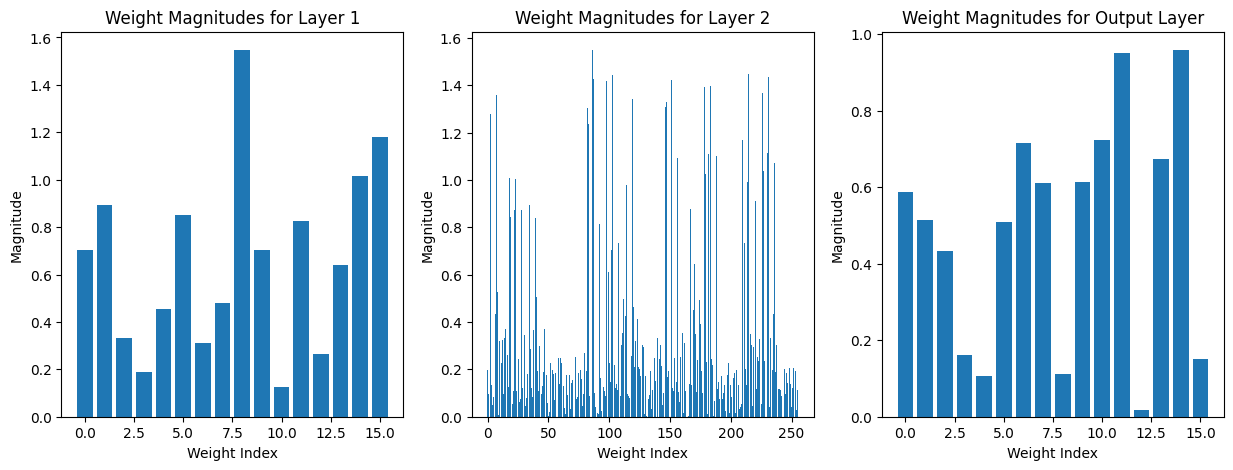

In [15]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns, figure size

# weights for layer 1
weights = model.layer1.weight.data.numpy()
axes[0].bar(range(len(weights.flatten())), np.abs(weights.flatten()))
axes[0].set_title("Weight Magnitudes for Layer 1")
axes[0].set_xlabel("Weight Index")
axes[0].set_ylabel("Magnitude")

# weights for layer 2
weights = model.layer2.weight.data.numpy()
axes[1].bar(range(len(weights.flatten())), np.abs(weights.flatten()))
axes[1].set_title("Weight Magnitudes for Layer 2")
axes[1].set_xlabel("Weight Index")
axes[1].set_ylabel("Magnitude")

# weights for output layer
weights = model.output.weight.data.numpy()
axes[2].bar(range(len(weights.flatten())), np.abs(weights.flatten()))
axes[2].set_title("Weight Magnitudes for Output Layer")
axes[2].set_xlabel("Weight Index")
axes[2].set_ylabel("Magnitude")

plt.show()